<a href="https://colab.research.google.com/github/nasiksami/FYP2-Codes/blob/main/(89_)InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Nov 27 12:30:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

import psutil
import humanize
import os
from IPython.display import display_html
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir())
dataDirectory= "/content/drive/MyDrive/dataset_resized" 
print(os.listdir(dataDirectory))

['.config', 'drive', 'sample_data']
['testing', 'training', 'models', 'SAVED_MODELS']


In [4]:
!rm -r ~/.keras
!mkdir ~/.keras
!mkdir ~/.keras/models
# not enough space for both
#!cp ../input/keras-pretrained-models/* ~/.keras/models/ 
#!cp ../input/vgg19/* ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
#!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [5]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.preprocessing.image import load_img,img_to_array
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline
import skimage.io
import os 
import glob
import tqdm
import tensorflow as tf

In [173]:
train_path = dataDirectory+'/training'
test_path  = dataDirectory+'/testing'
print(os.listdir(train_path))
print(os.listdir(test_path))

['cardboard292.jpg', 'cardboard33.jpg', 'cardboard69.jpg', 'ewaste', 'cardboard', 'glass', 'paper', 'metal', 'trash', 'plastic']
['trash', 'metal', 'plastic', 'ewaste', 'cardboard', 'glass', 'paper']


In [181]:
train_datagen = ImageDataGenerator(
        tf.keras.applications.mobilenet.preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        validation_split=0.2,
        #featurewise_center=True,
       featurewise_std_normalization=True,
       #zca_whitening=True
       )

In [8]:
selectedClasses = [ 'cardboard','ewaste', 'glass', 'metal','paper', 'plastic', 'trash'] 

In [186]:
batchSize=64

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='validation') # set as validation data

test_generator = ImageDataGenerator().flow_from_directory(
    test_path, 
    target_size=(224,224), 
    classes=selectedClasses,
    shuffle= False,
    batch_size = batchSize)# set as test data

Found 1931 images belonging to 7 classes.
Found 480 images belonging to 7 classes.
Found 608 images belonging to 7 classes.


In [187]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
print ("") 

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(test_generator.classes).count(cls))

In train_generator 
cardboard :	 256
ewaste :	 316
glass :	 320
metal :	 263
paper :	 380
plastic :	 308
trash :	 88

In validation_generator 
cardboard :	 63
ewaste :	 79
glass :	 80
metal :	 65
paper :	 95
plastic :	 77
trash :	 21

In test_generator 
cardboard :	 81
ewaste :	 100
glass :	 101
metal :	 82
paper :	 119
plastic :	 97
trash :	 28


In [ ]:
#plots images with labels within jupyter notebook
def plots(ims, figsize = (22,22), rows=4, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
    #cols = len(ims) //rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    #for i in range(len(ims)):
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')   

In [ ]:
train_generator.reset()
imgs, labels = train_generator.next()

#print(labels)

labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]
#print(labelIndices)

for ind in labelIndices:
    for labelName,labelIndex in train_generator.class_indices.items():
        if labelIndex == ind:
            #print (labelName)
            labelNames.append(labelName)

#labels

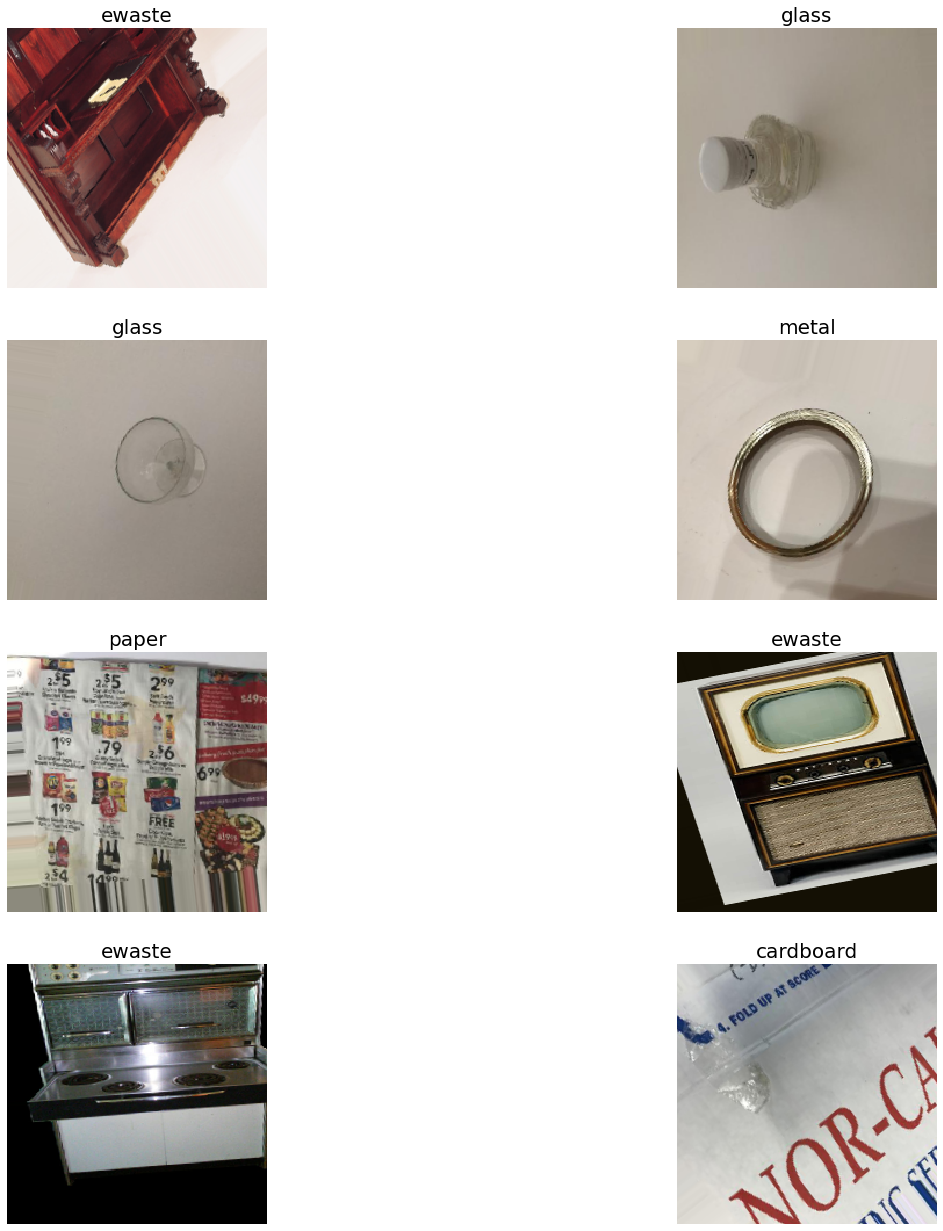

In [ ]:
plots(imgs, rows=4, titles = labelNames, maxNum=8)

In [188]:
tf.keras.applications.InceptionResNetV2(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax'
)

In [189]:
model = tf.keras.applications.InceptionResNetV2()


In [190]:
x = model.layers[-1].output

In [191]:
x = Flatten()(x)

In [192]:
output = Dense(units=7, activation='softmax')(x)

In [193]:
model = Model(inputs=model.input, outputs=output)

In [194]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [195]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

 
modelName= "mb"
filepath=modelName+"_bestweights.hdf5"
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 10,
                              verbose = 1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [earlystopping,checkpoint]

In [196]:
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)

stepsPerEpoch:  31
validationSteps:  8


In [197]:
train_generator.reset()
validation_generator.reset()

In [198]:
# Fit the model
history = model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs = 50,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=2)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
31/31 - 48s - loss: 1.9330 - accuracy: 0.3035 - val_loss: 1.9242 - val_accuracy: 0.3208
Epoch 2/50
31/31 - 44s - loss: 1.9059 - accuracy: 0.5422 - val_loss: 1.9061 - val_accuracy: 0.4750
Epoch 3/50
31/31 - 44s - loss: 1.8858 - accuracy: 0.6851 - val_loss: 1.8908 - val_accuracy: 0.5979
Epoch 4/50
31/31 - 44s - loss: 1.8738 - accuracy: 0.7266 - val_loss: 1.8792 - val_accuracy: 0.6771
Epoch 5/50
31/31 - 44s - loss: 1.8654 - accuracy: 0.7602 - val_loss: 1.8744 - val_accuracy: 0.6792
Epoch 6/50
31/31 - 44s - loss: 1.8568 - accuracy: 0.7851 - val_loss: 1.8651 - val_accuracy: 0.6938
Epoch 7/50
31/31 - 44s - loss: 1.8519 - accuracy: 0.7872 - val_loss: 1.8644 - val_accuracy: 0.6979
Epoch 8/50
31/31 - 44s - loss: 1.8443 - accuracy: 0.8042 - val_loss: 1.8624 - val_accuracy: 0.6625
Epoch 9/50
31/31 - 44s - loss: 1.8361 - accuracy: 0.8255 - val_loss: 1.8532 - val_accuracy: 0.7104
Epoch 10/50
31/31 - 44s - loss: 1.8288 - accuracy: 0.8483 - val_loss: 1.8634 - val_accuracy: 0.6187
Epoch 11/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


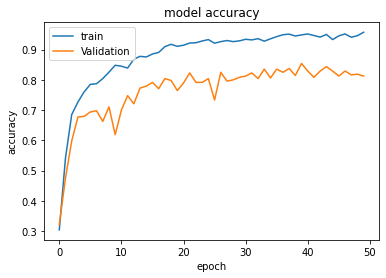

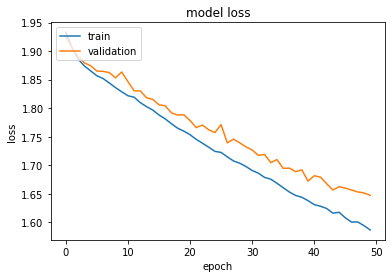

In [199]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [200]:
validation_generator.reset()
score = model.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("For validation data set; Loss: ",score[0]," Accuracy: ", score[1])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


For validation data set; Loss:  1.6419461965560913  Accuracy:  0.8291666507720947


In [201]:
test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (batchSize-1)) // batchSize)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  1.6168540716171265  Accuracy:  0.8881579041481018


In [202]:
train_generator.reset()
score = model.evaluate_generator(train_generator, (train_generator.samples + (batchSize-1)) // batchSize)
print("For training data set; Loss: ",score[0]," Accuracy: ", score[1])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


For training data set; Loss:  1.5855611562728882  Accuracy:  0.9575349688529968


In [203]:
test_generator.reset()
testStep = (test_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)
predictions = model.predict_generator(test_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  10
10/10 [==============================] - 5s 530ms/step


608

In [204]:
len(predictions)

608

In [205]:
predicted_class_indices=np.argmax(predictions,axis=1)
print(predicted_class_indices)
len(predicted_class_indices)

[0 0 0 4 0 4 4 0 4 0 1 4 0 0 4 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 4 0 0 0 0 0
 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 6 1 0 0 0 4 0 0 0 4 6 0 0 0 0 0
 0 0 0 0 0 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 4 1 1 1 1 1 1 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 5 2 2 2 2 2 2 2 2 2
 5 2 2 2 2 2 2 5 2 2 2 2 2 2 2 6 2 2 2 5 2 2 2 2 2 2 5 2 2 2 2 2 5 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 3 3 3 3 3 3 3 3 3 2 3 3 5 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 6 3
 3 6 3 2 6 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4
 4 4 5 5 5 5 4 6 5 5 5 4 

608

In [206]:
labels = (test_generator.class_indices)
print(labels)

{'cardboard': 0, 'ewaste': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}


In [207]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'cardboard', 1: 'ewaste', 2: 'glass', 3: 'metal', 4: 'paper', 5: 'plastic', 6: 'trash'}


In [208]:
predictedLables= [labels[k] for k in predicted_class_indices]
print(predictedLables)
len(predictedLables)

['cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'paper', 'paper', 'cardboard', 'paper', 'cardboard', 'ewaste', 'paper', 'cardboard', 'cardboard', 'paper', 'cardboard', 'ewaste', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'ewaste', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'ewaste', 'trash', 'ewaste', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'paper', 'trash', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'paper', 'ewaste', 'ewaste', 'ewast

608

In [209]:
actualLables= [labels[k] for k in test_generator.classes]
print(actualLables)
len(actualLables)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard'

608

In [210]:
accuracy_score(actualLables, predictedLables)

0.8881578947368421

In [211]:
matrix = confusion_matrix(actualLables, predictedLables)
print(labels)
matrix

{0: 'cardboard', 1: 'ewaste', 2: 'glass', 3: 'metal', 4: 'paper', 5: 'plastic', 6: 'trash'}


array([[ 62,   6,   0,   0,  11,   0,   2],
       [  0,  94,   0,   0,   6,   0,   0],
       [  0,   0,  91,   0,   1,   7,   2],
       [  0,   0,   4,  73,   0,   2,   3],
       [  0,   0,   0,   1, 117,   0,   1],
       [  0,   0,   4,   3,   5,  79,   6],
       [  0,   0,   0,   1,   2,   1,  24]])

In [212]:
print(classification_report(actualLables, predictedLables))

              precision    recall  f1-score   support

   cardboard       1.00      0.77      0.87        81
      ewaste       0.94      0.94      0.94       100
       glass       0.92      0.90      0.91       101
       metal       0.94      0.89      0.91        82
       paper       0.82      0.98      0.90       119
     plastic       0.89      0.81      0.85        97
       trash       0.63      0.86      0.73        28

    accuracy                           0.89       608
   macro avg       0.88      0.88      0.87       608
weighted avg       0.90      0.89      0.89       608



In [213]:
recall_score( actualLables, predictedLables,average='weighted') 

0.8881578947368421

In [214]:
precision_score( actualLables, predictedLables,average='weighted') 

0.8987115188790179

In [215]:
#Prepared code that is taken from SKLearn Website, Creates Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 62   6   0   0  11   0   2]
 [  0  94   0   0   6   0   0]
 [  0   0  91   0   1   7   2]
 [  0   0   4  73   0   2   3]
 [  0   0   0   1 117   0   1]
 [  0   0   4   3   5  79   6]
 [  0   0   0   1   2   1  24]]


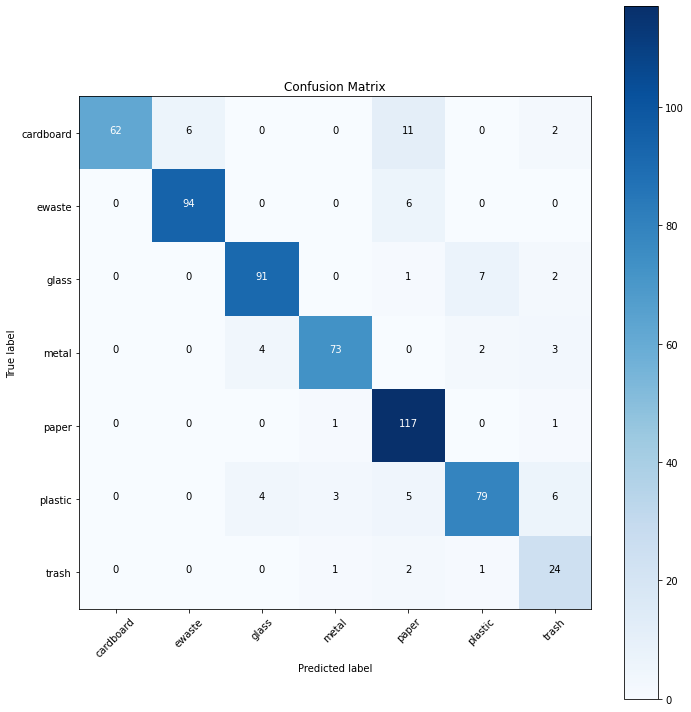

In [216]:
plt.figure(figsize=(10,10))
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix')


In [217]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/(89%)InceptionResNetV2.h5')

Alternate Code

In [218]:
import tensorflow as tf

In [219]:
test_labels= test_generator.classes

In [220]:
predictions = model.predict(x=test_generator, steps=len(test_generator), verbose=1)

10/10 [==============================] - 5s 536ms/step


In [221]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [222]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [223]:
test_generator.class_indices

{'cardboard': 0,
 'ewaste': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

Confusion matrix, without normalization
[[ 62   6   0   0  11   0   2]
 [  0  94   0   0   6   0   0]
 [  0   0  91   0   1   7   2]
 [  0   0   4  73   0   2   3]
 [  0   0   0   1 117   0   1]
 [  0   0   4   3   5  79   6]
 [  0   0   0   1   2   1  24]]


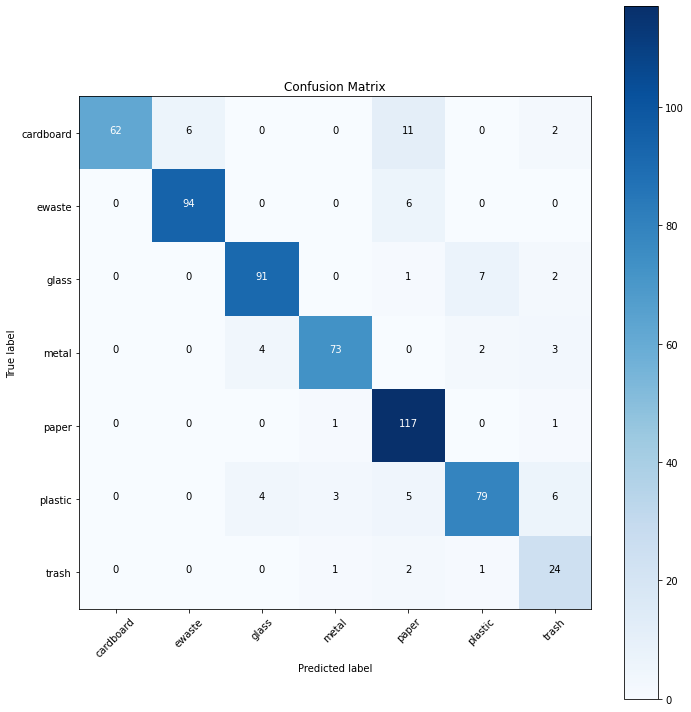

In [224]:
import itertools
plt.figure(figsize=(10,10))
cm_plot_labels = ['cardboard' ,'ewaste', 'glass', 'metal', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [225]:
test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (batchSize-1)) // batchSize)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  1.6168540716171265  Accuracy:  0.8881579041481018
